In [194]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [178]:
def get_X_2d_uniform(n, x0_min, x0_max, x1_min, x1_max):
    x0s = np.random.uniform(x0_min, x0_max, size = n)
    x1s = np.random.uniform(x1_min, x1_max, size = n)
    return np.stack([x0s, x1s], axis = 1)

def get_X_2d_interval(n, x0_min, x0_max, x1_min, x1_max):
    x0s = np.linspace(x0_min, x0_max, num = n)
    x1s = np.linspace(x1_min, x1_max, num = n)
    x0, x1 = np.meshgrid(x0s, x1s)
    return np.stack([x0.flatten(), x1.flatten()], axis = 1)

def gen_sine(n, drifted = False):
    x0_min, x0_max = -3.14, 3.14
    x1_min, x1_max = -1, 1
    X = get_X_2d_uniform(n, x0_min, x0_max, x1_min, x1_max)
    y = np.array((X[:, 1] > np.sin(X[:, 0])) != drifted).astype(int)
    return X, y

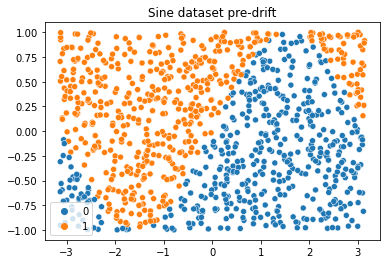

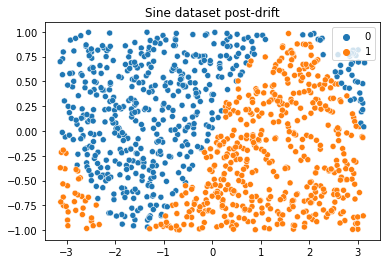

In [164]:
n_samples = 1000

X_pre, y_pre = gen_sine(n_samples)
X_post, y_post = gen_sine(n_samples, drifted = True)

plt.title('Sine dataset pre-drift')
sns.scatterplot(x = X_pre[:, 0], y = X_pre[:, 1], hue = y_pre)
plt.show()

plt.title('Sine dataset post-drift')
sns.scatterplot(x = X_post[:, 0], y = X_post[:, 1], hue = y_post)
plt.show()

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_pre, test_size = 0.25)

In [166]:
model = keras.Sequential(
    [
        keras.Input(shape = (2,)),
        keras.layers.Dense(4, activation="sigmoid"),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [167]:
hist = model.fit(
    x = X_train,
    y = y_train,
    epochs = 200,
    validation_split = 0.1,
    verbose = 0
)

In [168]:
hist_df = pd.DataFrame.from_dict(hist.history)

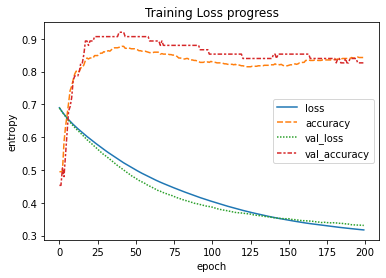

In [169]:
plt.title('Training Loss progress')

sns.lineplot(data = hist_df)
plt.xlabel('epoch')
plt.ylabel('entropy')
plt.show()

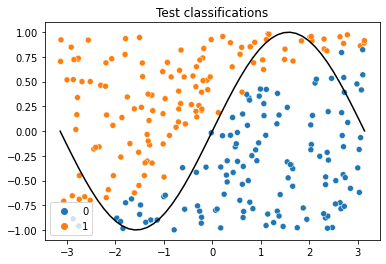

In [186]:
y_pre_pred = (model.predict(X_test)[:, 0] > 0.5).astype(int)

plt.title('Test classifications')

# training data 
#sns.scatterplot(x = X_train[:, 0], y = X_train[:, 1], hue = y_train, alpha = 0.1)

# pred data 
sns.scatterplot(x = X_test[:, 0], y = X_test[:, 1], hue = (y_pre_pred > 0.5).astype(int))

# underlying function
sns.lineplot(x = np.linspace(-3.14, 3.14), y = np.sin(np.linspace(-3.14, 3.14)), color = 'k')

plt.show()

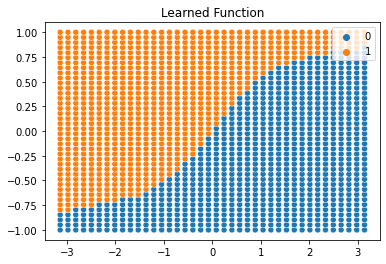

In [181]:
X_f = get_X_2d_interval(40, -3.14, 3.14, -1, 1)
y_pred_f = (model.predict(X_f)[:, 0] > 0.5).astype(int)

plt.title('Learned Function')

# pred data 
sns.scatterplot(x = X_f[:, 0], y = X_f[:, 1], hue = y_pred_f)

plt.show()

In [237]:
# pre-drift error rate
test_error_rate = 1 - accuracy_score(y_pre_pred, y_test)
print("Error rate pre-drift: %.1f%%" % (test_error_rate * 100))

Error rate pre-drift: 13.6%


Get the error rate over time

In [273]:
# get error rate over time with data that models the same concept as the test/train data
n_prod_pre = 1000
n_prod_post = 500
X_prod_pre, y_prod_pre = gen_sine(n_prod_pre, drifted = False)
X_prod_post, y_prod_post = gen_sine(n_prod_post, drifted = True)

X_prod = np.vstack([X_prod_pre, X_prod_post])
y_prod = np.concatenate([y_prod_pre, y_prod_post])

In [274]:
n_errors = 0
n_examples_seen = 0

err_rate_seq = []

for X, y in zip(X_prod, y_prod):
    
    X = np.expand_dims(X, axis = 0)
    y_pred = int(model.predict(X)[0] > 0.5)
    
    n_errors = n_errors + 1 if y_pred != y else n_errors
    n_examples_seen += 1
    err_rate_seq.append(n_errors / n_examples_seen)

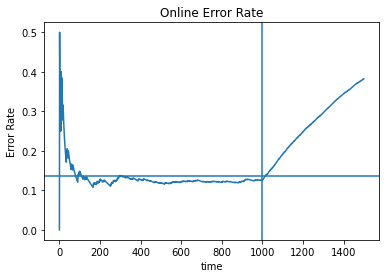

In [275]:
plt.title("Online Error Rate")
sns.lineplot(x = np.arange(0, n_prod_pre + n_prod_post), y = err_rate_seq)
plt.axhline(test_error_rate)
plt.axvline(n_prod_pre)
plt.ylabel('Error Rate')
plt.xlabel('time')
plt.show()

Above, the horizontal line is the test set error rate (pre-prod) and the vertial line is when the sudden drift happened in the prod data. We can see the error rate increasing dramatically at this point.

This image from Gama et al (2004) shows the same trend.
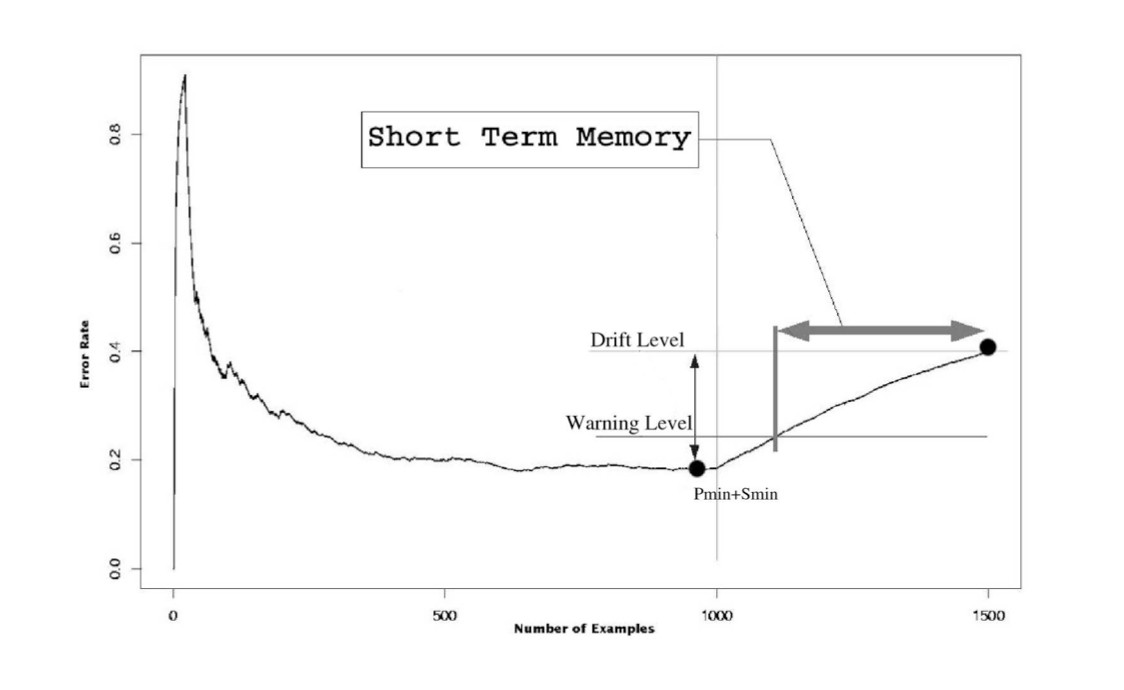